<h1>🤖 MLAI Workshop #03</h1>

Within this workshop we will discuss the importance of problem formulation in machine learning and explore the limitations associated with different approaches. We will focus on evaluating our models.

<h3>Agenda</h3>

1.   **Trade-offs associated with the learning problem** - we will quickly recap some of the concepts from prior workshops.
2.   **Explore problem formulation** - we will introduce problem formulation within the context of a simple classification problem.
3.   **Explore the limitations** - we will then uncover the limitations of the approach and explore an alternative formulations.
4.   **The bitter lesson in machine learning** - ...


<h3>Outcomes</h3>

1.   Gain an appreciation that every choice in the machine learning system imposes a biases about the solutions you can learn.
2.   Gain an appreciation for finding the weaknesses in machine learning models.

<h2>Section 0. The Learning Problem</h2>

In the first workshop we introduced the trade-offs involved in the learning problem - specifically how each of the hypothesis, dataset, and optimization spaces influence the final solution $\hat{f}$ we obtain.

<div align="center">
    <img src="https://github.com/nextgenerationgraduatesprogram/nextgen25-mlai-workshop03/raw/main/media/notebook/LearningProblem.png" height="600"/>
    <p><em>Figure 1. Illustration of the hypothesis, dataset, optimization, and target spaces considered in the learning problem.</em></p>
</div>

In the second workshop we built up a framework for performing flexible function approximation - which we used to approximate arbitrary functions over a defined domain.

1. Define a dataset.
2. Define a hypothesis space (model).
3. Optimize the hypothesis space under the dataset.
4. Analyse the results.

We explored how different aspects of the learning problem influenced our performance on a toy problem. Specifically, we explored a of the form:

\begin{align*}
  f: \mathcal{X} \to \mathcal{Y} \tag{1.1}\\
\end{align*}

where $\mathcal{X} \in \mathbb{R}^{1}$ and $\mathcal{Y} \in \mathbb{R}^{1}$. This reflects a simple one-dimensional regression task which is useful for building intuition about aspects of the learning problem.

In [ ]:
import torch
from typing import Callable

# create a dataset
class Dataset:
  def __init__(self, f: Callable, a: float, b: float, N: int = 100):
    super(Dataset, self).__init__()

    # Sample x uniformly in [a, b], shape [N,1]
    self.x = torch.rand(N, 1) * (b - a) + a

    # Observe f(x) through noise process, also [N,1]
    self.y = f(self.x) + torch.randn(N, 1) * 0.2

In [ ]:
import matplotlib.pyplot as plt

# define a target function i.e. your data generating process
f = lambda x: torch.exp(-x**2) * torch.sin(5.8 * torch.pi * x + 0.41)

# define a dataset with your function
dataset = Dataset(f, a=0, b=1, N=200)

# visualize the observations
fig, ax = plt.subplots(figsize=(8,2))
ax.scatter(dataset.x, dataset.y, s=6, label="observations")
ax.set_xlim(dataset.x.min(), dataset.x.max())
ax.legend(loc="best")
ax.set_xlabel("x_meas")
ax.set_ylabel("y_obs")

In [ ]:
import torch.nn as nn

class PerceptronLayer(nn.Module):
  """ single layer perceptron with a ReLU activation function as a non-linear basis
  """
  def __init__(self, input_dim: int, output_dim: int, act: bool = True):
    super(PerceptronLayer, self).__init__()
    self.fc = nn.Linear(input_dim, output_dim)
    self.act = nn.ReLU() if act else nn.Identity()

  def forward(self, x):
    x = self.act(self.fc(x))
    return x


class MultiLayerPerceptron(nn.Module):
  """ stack multiple layers of perceptrons to build more complex functions (mappings)
  """
  def __init__(self, hidden_layers: int = 0, hidden_dim: int = 1, input_dim: int = 1, output_dim: int = 1):
    super(MultiLayerPerceptron, self).__init__()

    # define the input layer
    modules = [PerceptronLayer(input_dim, hidden_dim)] # maps input_dim -> hidden_dim

    # define the hidden layers
    for _ in range(hidden_layers):
      modules.append(PerceptronLayer(hidden_dim, hidden_dim)) # maps hidden_dim -> hidden_dim

    # define the output layer
    modules.append(PerceptronLayer(hidden_dim, output_dim, act=False)) # maps hidden_dim -> output_dim

    # store the layers
    self.layers = nn.ModuleList(modules) # store layers

  def forward(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

In [442]:
from tqdm import tqdm

# define a training loop
def training_loop(model, optimizer, loss_fn, dataset, steps):
  losses = []
  with tqdm(range(steps)) as pbar:
    for idx in pbar:
      optimizer.zero_grad()
      y_pred = model(dataset.x)
      loss = loss_fn(dataset.y, y_pred)
      losses.append(loss)
      loss.backward()
      optimizer.step()
      pbar.set_description(f"loss: {loss.item():.3f}")
    return model, torch.tensor(losses)

# define some functions for plotting our results
def plot_loss_curve(losses):
    fig, ax = plt.subplots(figsize=(8,3))
    ax.plot(losses, label="loss")
    ax.set_xlim(left=0, right=len(losses)-1)
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Loss (MSE)")
    ax.set_title("Loss Curve")
    ax.grid(True, alpha=0.50)
    ax.legend()
    return fig, ax

def plot_predictions(model, dataset, ax = None):
    if ax is None: fig, ax = plt.subplots(figsize=(8,3))
    with torch.no_grad():
        ax.scatter(dataset.x, model(dataset.x), s=4, label="predictions")
        ax.scatter(dataset.x, dataset.y, s=4, label="observations")
    ax.set_xlim(left=dataset.x.min(), right=dataset.x.max())
    ax.grid(True, alpha=0.50)
    ax.legend(loc="best")
    return ax

When training our models we generally want our setup to have several properties:


1.   We want the dataset to sufficiently represent the data generating process.
2.   We want the hypothesis space to be large enough to accurately approximate the dataset.
3.   We need our optimizer to be capable of finding a suitable set of solutions.



In [447]:
# 1. Define a dataset
dataset = Dataset(f, a=0, b=1, N=200)

# 2. Define a hypothesis space
model = MultiLayerPerceptron(hidden_layers=0, hidden_dim=10)

# 3. Optimize the model under the dataset
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
loss_fn = torch.nn.MSELoss()
model, losses = training_loop(model, optimizer, loss_fn, dataset, steps=500)

loss: 0.174: 100%|██████████| 500/500 [00:02<00:00, 188.16it/s]


<Axes: >

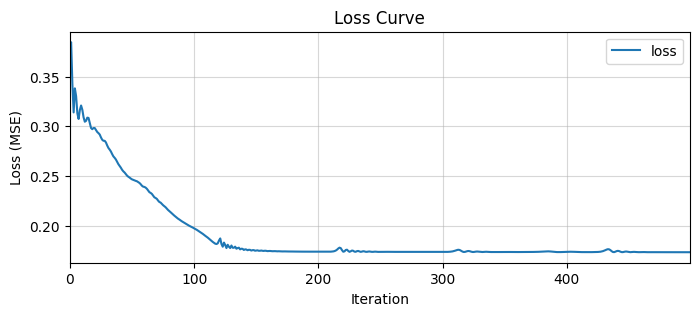

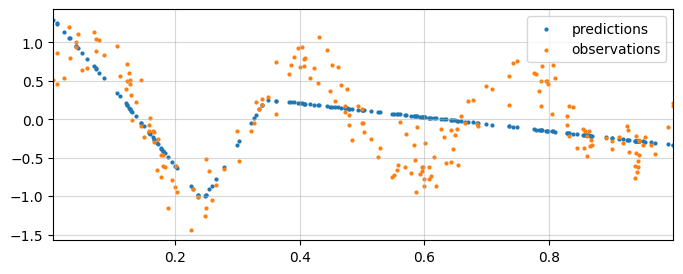

In [448]:
# 4. Analyse the results
plot_loss_curve(losses)
plot_predictions(model, dataset)

We also investigated some of the challenges inherent in learning from data in terms of interpolation and extrapolation performance. We saw that our interpolation error is typically bounded by our ability to resolve changes in the data manifold.

loss: 0.044: 100%|██████████| 500/500 [00:04<00:00, 112.24it/s]


(0.0, 1.0)

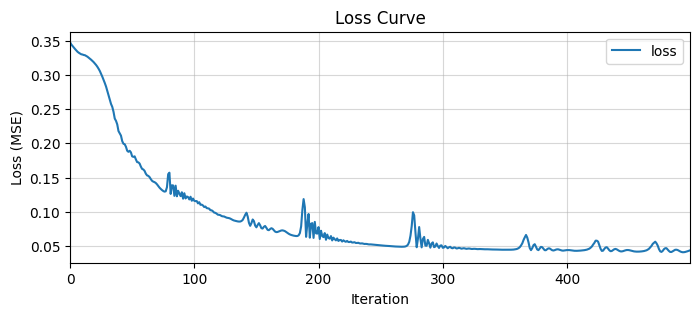

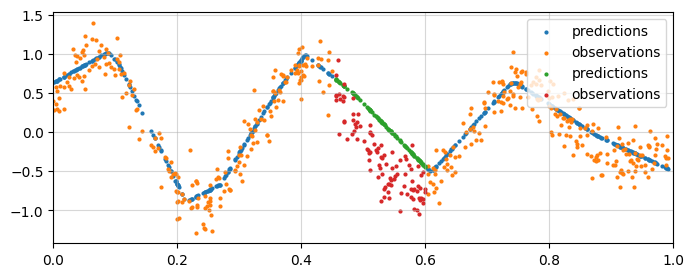

In [449]:
# 1. Define a dataset
dataset = Dataset(f, a=0, b=1, N=500)

# 1a. Erasing a region of the input domain
x_min, x_max = 0.45, 0.60
keep_idxs = (dataset.x < x_min) | (dataset.x > x_max)
dataset.x = dataset.x[keep_idxs].unsqueeze(-1)
dataset.y = dataset.y[keep_idxs].unsqueeze(-1)

# 2. Define a hypothesis space
model = MultiLayerPerceptron(hidden_layers=2, hidden_dim=20)

# 3. Optimize the model under the dataset
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()
model, losses = training_loop(model, optimizer, loss_fn, dataset, steps=500)

# 4. Analyse the results
plot_loss_curve(losses)
ax = plot_predictions(model, dataset)

# 4a. How well does it interpolate?
dataset_interp = Dataset(f, a=x_min, b=x_max, N=100)
ax = plot_predictions(model, dataset_interp, ax)
ax.set_xlim(0, 1)

We extended this to the extrapolation region - where we perform inference on data outside the convex hull of our training distribution - without data to constrain the behaviour we typically observe poor generalization.

Perfect generalization would require our network to have learned the function governing the data generating process - this isn't what our framework is designed for - our framework is design to approximate functions.

(-0.5, 1.5)

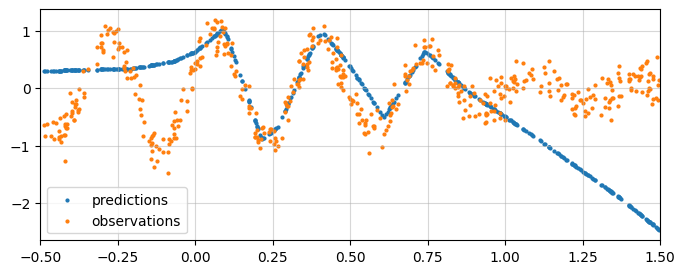

In [450]:
# 4b. How well does it extrapolate?
dataset_extrap = Dataset(f, -0.5, 1.5, 500)
ax = plot_predictions(model, dataset_extrap)
ax.set_xlim(-0.5, 1.5)

We expect this behaviour based on how our framework is defined - the learning problem is posed such that we learn to approximate the function defined by the training distribution. We built up our multi-layer perceptron to hierarchically construct a piecewise linear approximation of the function.

Within this context, the representational capacity of neural networks is typically focussed on resolving the curvature of the dataset manifold - there is no constraint our representing the manifold outside the convex hull.

In [451]:
# we can print the structure of the model
model

MultiLayerPerceptron(
  (layers): ModuleList(
    (0): PerceptronLayer(
      (fc): Linear(in_features=1, out_features=20, bias=True)
      (act): ReLU()
    )
    (1-2): 2 x PerceptronLayer(
      (fc): Linear(in_features=20, out_features=20, bias=True)
      (act): ReLU()
    )
    (3): PerceptronLayer(
      (fc): Linear(in_features=20, out_features=1, bias=True)
      (act): Identity()
    )
  )
)

In [ ]:
# cache for network activations
activations = {}

# define a forward pass hook to grab the outputs
def make_hook(name):
  def hook(module, input, output):
    # detach to avoid keeping the full graph
    activations[name] = output.detach().cpu()
  return hook

# register model hooks to the ReLU outputs
for idx, layer in enumerate(model.layers):
  if not layer.act._forward_hooks:
    layer.act.register_forward_hook(make_hook(f"layer_{idx}_relu"))

# run a forward pass on region to populate activations
x = torch.linspace(-1, 2, steps=1000).unsqueeze(-1)
_ = model(x)

In [ ]:
# which perceptron to inspect
layer_index = 1
perceptron_indexes = [0, 1, 2, 3, 4]

# acts is of shape [N, output_dim]
fig, ax = plt.subplots(figsize=(8,3))
for perceptron_index in perceptron_indexes:
  ax.plot(x, activations[f"layer_{layer_index}_relu"][:,perceptron_index], label=f"layer_{layer_index}_relu:{perceptron_index}")
ax.set_title(f"Perceptron Activations")
ax.set_xlabel("x")
ax.set_ylabel("activation")
ax.set_xlim(x.min(), x.max())

Thus far, we have focused on the general formulation of our function approximation - explored how factors like model capacity, data distribution, and optimization dynamics influence the solutions we learn - and identified some of the limitations inherent in our approach. With the recap done, we will spend the rest of the workshop exploring how we can apply this framework to solve more complex problems...

---

<h2>Section 1. Problem Formulation</h2>

We will focus on applying this framework to different problem settings - in doing so we'll discuss how the structure and representation of our learning task impacts the solutions we can learn and the nature of the insight we can glean.

The process of problem formulation is usually extremely problem specific and quite unclear - often this process is guided by our observations of the literature and a healthy dose of creativity/intuition. As we step through it, we will talk about it in an abstract manner - and ground this using a simple example.

We're going to explore this in the following steps:
1. Define the outputs.
2. Define our constraints.
3. Formulate an approach...
4. Define the inputs.
5. Define the hypothesis space.
6. Train, evaluate, analyse, and iterate.

<h3>Section 1.1 Spiral Arm Classification</h3>

Let's consider a problem setting - we're working with a team to analyse the structure of the arms of spiral galaxies - our objective is to classify which arm of a spiral dataset each star belongs to.

In [1]:
import torch
import numpy as np


class Spiral():
  def __init__(self, N: int = 100, noise: float = 0.2, ratio: float = 1.0, angle: float = .0):
    # angle
    theta = ratio * 1.5 * np.sqrt(np.random.rand(N)) * 2 * np.pi
    r_a = 2 * theta + np.pi / 2
    r_b = -2 * theta - np.pi / 2

    # Spiral A (label 0)
    x_a = np.stack([np.cos(theta) * r_a, np.sin(theta) * r_a], axis=1)
    x_a += np.random.randn(N, 2) * noise
    y_a = np.zeros(N)

    # Spiral B (label 1)
    x_b = np.stack([np.cos(theta) * r_b, np.sin(theta) * r_b], axis=1)
    x_b += np.random.randn(N, 2) * noise
    y_b = np.ones(N)

    # format
    x = np.concatenate([x_a, x_b], axis=0)
    y = np.concatenate([y_a, y_b], axis=0)
    x = torch.tensor(x, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # for BCE loss

    # rotate
    if angle != 0.0:
      c, s = np.cos(angle), np.sin(angle)
      R = torch.tensor([[c, -s], [s,  c]], dtype=torch.float32)
      x = x @ R.T

    self.x = x
    self.y = y


class SpiralDataset():
  """
  Generates a 2D spiral dataset with two arms (binary classification).
  Returns:
      x: Tensor of shape [2N, 2]
      y: Tensor of shape [2N] with labels 0 or 1
  """
  def __init__(self, n_spirals: int, noise: list, ratio: list, angle: list) -> None:
    #
    self.spirals = [Spiral(
        N=n_spirals, noise=np.random.uniform(noise[0], noise[1]), ratio=np.random.uniform(ratio[0], ratio[1]), angle=np.random.uniform(angle[0], angle[1])
    ) for _ in range(n_spirals)]

  def __len__(self) -> int:
    return len(self.spirals)

  def __getitem__(self, index: int) -> tuple:
    spiral = self.spirals[index]
    return spiral.x, spiral.y

AttributeError: 'tuple' object has no attribute 'y'

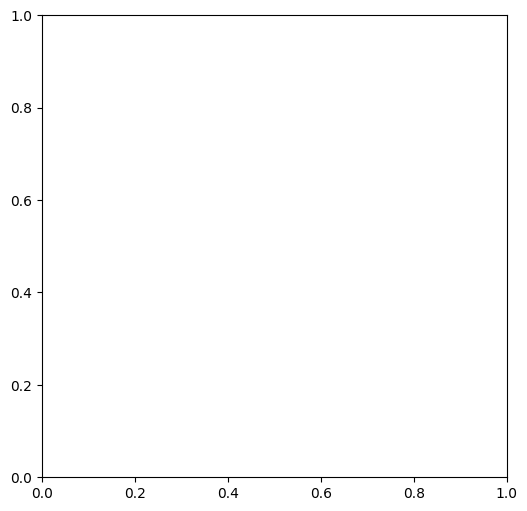

In [2]:
import matplotlib.pyplot as plt

# define the dataset
dataset = SpiralDataset(n_spirals=1, noise=[0.2, 0.5], ratio=[1.00, 1.50], angle=[.0,np.pi/2])

# select a sample
x, y = dataset.__getitem__(0)

# visualize the dataset
fig, ax = plt.subplots(figsize=(6,6))
mask0 = dataset.__getitem__(0).y.squeeze() == 0 # class A
ax.scatter(dataset.__getitem__(0).x[mask0, 0], dataset.__getitem__(0).x[mask0, 1], color="darkblue", label="Class A", edgecolor="black")
mask1 = dataset.__getitem__(0).y.squeeze() == 1 # class B
ax.scatter(dataset.__getitem__(0).x[mask1, 0], dataset.__getitem__(0).x[mask1, 1], color="darkred", label="Class B", edgecolor="black")
ax.set_title("Spiral Dataset")
ax.grid(True, alpha=0.50)
ax.set_xlabel(r"$x_{0}$")
ax.set_ylabel(r"$x_{1}$")
ax.legend(loc="best")

We can investigate the structure of this dataset and observe that we have $400$ samples, and each sample consists of:

\begin{align*}
  x \in \mathbb{R}^{2}, \quad y \in \{0, 1\}
\end{align*}

where $x = (x_{0}, x_{1})$ represents the position of a sample in cartesian coordinates and $y \in \{0, 1\}$ represents the class label of the position i.e. spiral A (class label 0) or B (class label 1).

In [ ]:
# how is the data stored?
print(f"x shape: {dataset.x.shape}, dtype: {dataset.x.dtype}")
print(f"y shape: {dataset.y.shape}, dtype: {dataset.y.dtype}")
print("")

# what does a single sample look like?
print(f"X_0 = (x_0, x_1) = {dataset.x[0]}")
print(f"Y_0 = {dataset.y[0]}")

<h3>Section 1B. What are we trying to predict?</h3>

We are given the goal to classify the spiral arms in our dataset. The first question to ask is:

> What do we want our model to learn - and why?

There are many valid ways to formulate a learning problem, even with the same data - different formulations represent slight different objectives and interpretations of the problem:

*   Do you want to predict which class a point belongs to? This is a very direct formulation.
*   Do you want to predict the probability that a point belongs to each class? This probabilistic output allows us to assess confidence and build more interpretable or robust systems.
*   Do you want to predict the signed distance to the decision boundary? This provides both classification and geometric insights into the data structure.
*   Do you want to predict the polar (angular) coordinate of a point? This provides a structural representation of the curve - that we could also use for classification.
*   Do you want to learn to reconstruct the input or discover its latent structure? This allows the model to uncover intrinsic geometry without needing labels, and supports tasks like clustering or generation.

Each approach uses the same data and achieves the same goal but approaches it in a slightly different manner.

> 💡 Choosing the right formulation is a design decision — one that aligns your learning system with the actual goal you care about.

📌 Let's assume we want to directly predict which class a point belongs to - hard classification. We want some function $f$, that takes in some input $x$, that directly predicts the class label $y \in \{0, 1\}$:

\begin{align*}
  f: x \in ... \mapsto y \in \{0, 1\}
\end{align*}

In [ ]:
# our dataset is already stored in this format
dataset.y.shape

In [ ]:
torch.unique(dataset.y)

💬 *What is your goal? How have your formulated your learning problem - what specifically are you trying to predict?*

<h3>Section 1C. How should we structure our inputs?</h3>

With a clear problem formulation in place, the next decision to make is: how should we represent the input and output data for the model? This is a critical step in the design of machine learning systems that bakes in strong assumptions about:

*   What kind of structure we believe the data has.
*   What kind of operations we want the model to learn.
*   What biases we want to encode into the hypothesis space.

The same underlying data can be represented in many different ways:

*   A rasterized image, where we discretize the input space into a grid.
*   A point cloud, where each point is a 2D coordinate in continuous space.
*   A graph, where edges might encode spatial or similarity relationships.
*   A sequence, where each point links to a subsequent point.

Each representation encodes different assumptions about the structure of the data.

In [ ]:
# rasterize the data
def rasterize_by_class(X, y, bins=100):
    x0_min, x0_max = X[:,0].min(), X[:,0].max()
    x1_min, x1_max = X[:,1].min(), X[:,1].max()

    # Separate class 0 and class 1
    X0 = X[y.squeeze() == 0]
    X1 = X[y.squeeze() == 1]

    hist0, _, _ = np.histogram2d(X0[:,0], X0[:,1], bins=bins, range=[[x0_min, x0_max], [x1_min, x1_max]])
    hist1, _, _ = np.histogram2d(X1[:,0], X1[:,1], bins=bins, range=[[x0_min, x0_max], [x1_min, x1_max]])

    # Normalize histograms to [0,1] for color intensity
    hist0 /= hist0.max()
    hist1 /= hist1.max()

    # Combine into RGB image: Red for class 1, Blue for class 0
    rgb = np.zeros((bins, bins, 3))
    rgb[..., 0] = hist1.T  # Red channel
    rgb[..., 2] = hist0.T  # Blue channel

    return rgb, (x0_min, x0_max, x1_min, x1_max)

# rasterize
rgb, extent = rasterize_by_class(dataset.x, dataset.y, bins=50)

# plot image
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(rgb, extent=extent)
ax.set_title("Rasterized Spiral (Image-like)")
ax.set_xlabel("$x_0$")
ax.set_ylabel("$x_1$")
ax.grid(True, alpha=0.50)


In [ ]:
from sklearn.neighbors import kneighbors_graph
import networkx as nx

A = kneighbors_graph(dataset.x, n_neighbors=6, mode='connectivity')
G = nx.from_scipy_sparse_array(A)

pos = {i: (dataset.x[i, 0], dataset.x[i, 1]) for i in range(len(dataset.x))}
colors = ['blue' if label == 0 else 'red' for label in dataset.y]

fig, ax = plt.subplots(figsize=(6, 6))
nx.draw(G, pos, node_color=colors, node_size=20, edge_color='gray', ax=ax)
ax.set_title("Graph View (k-NN)")
ax.set_xlabel("$x_0$")
ax.set_ylabel("$x_1$")
ax.grid(True, alpha=0.50)

📌 For our spiral dataset, we'll assume a point cloud representation, where each input is simply a pair of coordinates in continuous space using Cartesian coordinates:

\begin{align*}
  x = (x_{0}, x_{1}) \in \mathbb{R}^{2}
\end{align*}

This feels like a reasonable representation for our data and encodes a low number of assumptions about the structure of the data (i.e. no grid, no toplogy, no structure) - this also has downsides (i.e. no geometric context). Hence, we have defined our input:

\begin{align*}
  f : x \in \mathbb{R}^{2} \mapsto y \in \{0, 1\}
\end{align*}

In [ ]:
# visualize the dataset
fig, ax = plt.subplots(figsize=(6,6))
mask0 = dataset.y.squeeze() == 0
ax.scatter(dataset.x[mask0, 0], dataset.x[mask0, 1], color="darkblue", label="Class A", edgecolor="black")
mask1 = dataset.y.squeeze() == 1
ax.scatter(dataset.x[mask1, 0], dataset.x[mask1, 1], color="darkred", label="Class B", edgecolor="black")
ax.set_title("Spiral Dataset")
ax.grid(True, alpha=0.50)
ax.set_xlabel(r"$x_{0}$")
ax.set_ylabel(r"$x_{1}$")
ax.legend(loc="best")

💬 *What is your input data? How do you represent your inputs for your model? What assumptions does that representation encode?*

You might also extend this discussion on how we represent our data to include pre-processing steps such as normalization - these sort of steps adjust the structure and distribution of the input and interacts strongly with aspects of our modelling approach such as parameter initialization, which in turn influence what and how we learn.

<h3>Section 1D. Hypothesis Space & Network Structure</h3>

So far we have defined how the input and output data is represented. Now we can decide what sort of hypothesis space will we chose to learn this function? Each representation implies a different formulation - and thus different modeling strategies are typically used:

*   Images $\rightarrow$ CNNs, Transformers, etc.
*   Point clouds $\rightarrow$ MLPs, Transformers, etc.
*   Graphs $\rightarrow$ GNNs, MPNNs, Transformers, etc.
*   Sequences $\rightarrow$ RNNs, Transformers, etc.

> 💡 Data representation is not just about data formatting - its a modeling choice - that has significant impacts on the learning process.

📌 We have been working so far with multi-layer perceptrons, this is a reasonable model class to use in this scenario. We want our MLP, $f$, to take as input the 2D coordinates:

\begin{align*}
  x = (x_{0}, x_{1}) \in \mathbb{R}^{2}
\end{align*}

and output a scalar value representing the class label.

\begin{align*}
  y \in \{0, 1\}
\end{align*}

We can define a network architecture that achieves this by abstracting our previous model architecture:

In [ ]:
""" reference model
class MultiLayerPerceptron(nn.Module):
  def __init__(self, hidden_layers: int = 0, hidden_dim: int = 1, input_dim: int = 1, output_dim: int = 1):
    super(MultiLayerPerceptron, self).__init__()
    modules = [PerceptronLayer(input_dim, hidden_dim)] # input layer
    for _ in range(hidden_layers): modules.append(PerceptronLayer(hidden_dim, hidden_dim)) # hidden layers
    modules.append(PerceptronLayer(hidden_dim, output_dim, act=False)) # output layer (no activation)
    self.layers = nn.ModuleList(modules) # store layers

  def forward(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
"""

# design your own model...
class PointClassificationMultiLayerPerceptron(nn.Module):
  def __init__(self, hidden_layers: int = 0, hidden_dim: int = 1):
    # how many inputs...
    # how many outputs...
    ...

  def forward(self, x):
    # apply model layers...
    ...

<h3>Section 1E. Training and evaluating the model</h3>

We can go ahead and train our model on our dataset; this might take some tweaking of the model and optimization process.

In [ ]:
def training_loop(model, optimizer, loss_fn, dataset, steps):
  losses = []
  with tqdm(range(steps)) as pbar:
    for idx in pbar:
      optimizer.zero_grad()
      y_pred = model(dataset.x)
      loss = loss_fn(y_pred, dataset.y) # input=logits, target=labels
      losses.append(loss)
      loss.backward()
      optimizer.step()
      pbar.set_description(f"loss: {loss.item():.3f}")
    return model, torch.tensor(losses)

def plot_predictions(model, dataset):
    # evaluate model
    with torch.no_grad():
        logits = model(dataset.x)
        probs = torch.sigmoid(logits)
        preds = (probs >= 0.5).float().cpu().numpy().squeeze()

    # Prepare data
    x_np = dataset.x.cpu().numpy()

    # Plot predictions (color = model prediction)
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(x_np[:, 0], x_np[:, 1], c=preds, cmap="RdBu", edgecolor="k", label="Predictions")

    ax.set_title("Model Predictions (Hard Classification)")
    ax.set_xlabel(r"$x_0$")
    ax.set_ylabel(r"$x_1$")
    ax.set_aspect("equal")
    ax.legend(loc="best")
    ax.grid(True, alpha=0.50)
    return fig, ax

In [ ]:
dataset = SpiralDataset(N=10, noise=1.50)
model = PointClassificationMultiLayerPerceptron(hidden_layers=0, hidden_dim=2)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
loss_fn = torch.nn.BCEWithLogitsLoss()
model, losses = training_loop(model, optimizer, loss_fn, dataset, steps=100)

In [ ]:
_ = plot_loss_curve(losses)

In [ ]:
_ = plot_predictions(model, dataset)

We can see we might be getting some reasonable predictions now. An interesting question to ask is what does the model predict across the entire domain i.e. outside of the spirals?

In [ ]:
def plot_spiral_classification(
  model,
  dataset,
  grid_range=(-25, 25),
  grid_size=500,
  levels=10,
):
  """
  Plot model predictions over the 2D spiral input space alongside the true data points.
  """
  model.eval()
  # Create meshgrid over specified range
  x_min, x_max = grid_range
  y_min, y_max = grid_range
  xx, yy = torch.meshgrid(
      torch.linspace(x_min, x_max, grid_size),
      torch.linspace(y_min, y_max, grid_size),
      indexing='ij'
  )
  grid = torch.stack([xx.flatten(), yy.flatten()], dim=1)

  # Predict probabilities on grid
  with torch.no_grad():
      logits = model(grid)
      probs = torch.sigmoid(logits).reshape(xx.shape).cpu().numpy()

  # Plot contour of predicted probabilities
  fig, ax = plt.subplots(figsize=(6, 6))
  contour = ax.contourf(
      xx.cpu().numpy(), yy.cpu().numpy(), probs,
      levels=levels, cmap="RdBu", alpha=0.50
  )

  # Overlay true data points
  X_data = dataset.x.cpu().numpy()
  y_data = dataset.y.squeeze().cpu().numpy()
  ax.scatter(
      X_data[:, 0], X_data[:, 1],
      c=y_data, cmap="RdBu", edgecolor='k', label='Ground Truth'
  )

  ax.set_title("Spiral Classification")
  ax.set_xlim(x_min, x_max)
  ax.set_ylim(y_min, y_max)
  ax.set_xlabel(r"$x_0$")
  ax.set_ylabel(r"$x_1$")
  ax.set_aspect("equal")
  ax.legend(loc="best")
  plt.tight_layout()
  return fig, ax


In [ ]:
_ = plot_spiral_classification(model, dataset)

We can think about what we're asking the network to do here, and how this shapes what it learns. We can think of the network as learning a height function (a surface) over the 2D input plane:

\begin{align*}
  y = f(x_{0}, x_{1})
\end{align*}

In its raw form, the spirals are not linearly separable - theres no straight line we can draw to separate the classes. But, once we “lift” each point up to its height $y$, the spirals trace out two separate ridges on the surface. A simple horizontal cut—say at $y = 0.5$ now cleanly slices the surface into two regions, each containing exactly one spiral. This enables classification.



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

def plot_spiral_classification_3d(
    model,
    dataset,
    grid_range=(-25, 25),
    grid_size=500,
    cmap="RdBu",
    alpha=0.8,
    point_size=20
):
    """
    Plot model predictions as a 3D surface over the 2D spiral input space,
    with true data points projected onto the surface.
    """
    model.eval()

    # 1) Create meshgrid
    x_min, x_max = grid_range
    y_min, y_max = grid_range
    xx = np.linspace(x_min, x_max, grid_size)
    yy = np.linspace(y_min, y_max, grid_size)
    XX, YY = np.meshgrid(xx, yy)
    grid = np.stack([XX.ravel(), YY.ravel()], axis=1)
    grid_t = torch.tensor(grid, dtype=torch.float32)

    # 2) Predict
    with torch.no_grad():
        logits = model(grid_t)
        probs = torch.sigmoid(logits).cpu().numpy().reshape(XX.shape)

    # 3) Plot
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d")

    # Surface
    surf = ax.plot_surface(
        XX, YY, probs,
        rstride=5, cstride=5,
        cmap=cmap, edgecolor='none', alpha=alpha
    )

    # Scatter data points at their true probabilities (0 or 1)
    Xd = dataset.x.cpu().numpy()
    yd = dataset.y.squeeze().cpu().numpy()
    # Evaluate model at data points for actual height
    with torch.no_grad():
        dp = torch.sigmoid(model(dataset.x)).cpu().numpy().squeeze()
    ax.scatter(
        Xd[:, 0], Xd[:, 1], dp,
        c=yd, cmap="RdBu",
        edgecolor='k', s=point_size,
        label="Data Predictions"
    )

    ax.set_title("3D Spiral Classification Surface")
    ax.set_xlabel("$x_0$")
    ax.set_ylabel("$x_1$")
    ax.set_zlabel("Predicted Probability")
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label="P(class=1)")
    ax.view_init(elev=30, azim=-60)
    plt.tight_layout()
    return fig, ax


fig, ax = plot_spiral_classification_3d(model, dataset)
plt.show()

In other words, rather than trying to draw a winding curve in the plane, the network learns to warp the data into the third dimension so that a single flat plane can separate the classes. This makes sense - the objective of classification is to separate the classes.

This is exactly analogous to how, in 1D, we use ReLU “kinks” to approximate a curve by piecewise-linear segments: in 2D we use ReLU “creases” to build a surface whose level sets (planes $z = const.$) implement our decision boundary.








In previous workshops we built up an understanding that each Perceptron learns a linear combination of its inputs and applies some non-linear activation function. We can investigate what each neuron is doing in this model too...

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def plot_layer_neuron_response(
    model,
    dataset,
    layer_idx: int = 0,
    neuron_idx: int = 0,
    bounds: float = 25,
    resolution: int = 500,
    cmap: str = "RdBu",
    alpha: float = 0.6
):
    """
    Visualize the activation of a single neuron in a given PerceptronLayer
    over the 2D input plane.

    Args:
        model:          a MultiLayerPerceptron with .layers (ModuleList of PerceptronLayer)
        dataset:        object with .x (Tensor[N,2]) and .y (Tensor[N,1])
        layer_idx:      index into model.layers to probe
        neuron_idx:     which output neuron of that layer to visualize
        bounds:         axes range [-bounds, +bounds]
        resolution:     number of grid points per axis
        cmap:           heatmap colormap
        alpha:          heatmap transparency
    Returns:
        fig, ax:        Matplotlib figure and axes
    """
    assert hasattr(model, "layers"), "Model must have a .layers attribute"
    assert 0 <= layer_idx < len(model.layers), f"layer_idx out of range [0, {len(model.layers)-1}]"

    model.eval()
    # 1) build grid
    xs = torch.linspace(-bounds, bounds, resolution)
    ys = torch.linspace(-bounds, bounds, resolution)
    xx, yy = torch.meshgrid(xs, ys, indexing="ij")
    grid = torch.stack([xx.flatten(), yy.flatten()], dim=1)  # [res^2, 2]

    # 2) forward through layers up to layer_idx
    with torch.no_grad():
        h = grid
        for i, layer in enumerate(model.layers):
            h = layer(h)
            if i == layer_idx:
                break
        activations = h[:, neuron_idx].reshape(xx.shape).cpu().numpy()

    # 3) plot
    fig, ax = plt.subplots(figsize=(6, 6))
    pcm = ax.contourf(
        xx.cpu().numpy(),
        yy.cpu().numpy(),
        activations,
        levels=50,
        cmap=cmap,
        alpha=alpha
    )
    fig.colorbar(pcm, ax=ax, label=f"Layer {layer_idx} Neuron {neuron_idx} Activation")

    # overlay data
    X_data = dataset.x.cpu().numpy()
    y_data = dataset.y.squeeze().cpu().numpy()
    ax.scatter(
        X_data[:, 0], X_data[:, 1],
        c=y_data, cmap=cmap,
        edgecolor="k", s=15, label="Data"
    )

    ax.set_title(f"Activation of Neuron {neuron_idx} in Layer {layer_idx}")
    ax.set_xlim(-bounds, bounds)
    ax.set_ylim(-bounds, bounds)
    ax.set_xlabel("$x_0$")
    ax.set_ylabel("$x_1$")
    ax.set_aspect("equal")
    ax.legend(loc="best")
    plt.tight_layout()
    return fig, ax

fig, ax = plot_layer_neuron_response(
    model=model,
    dataset=dataset,
    layer_idx=1,
    neuron_idx=5,
)

In a $D$ dimensional input space, an MLP with ReLU activations alternates linear projections (affine mappings h=Wx+b) with folds (ReLU clamps along each coordinate’s hyperplane). This composition partitions $\mathbb{R}^{D}$ into a mosaic of convex polytopes, within each of which the network's overall mapping is exactly affine. By stacking many project-and-fold layers, deep nets “untangle” complex manifolds so that a single final hyperplane can cleanly separate the classes.

*An aside on manifolds...*

Real-world data—whether images, audio, or text—rarely fills its high-dimensional input space uniformly. Instead, it lies on a much lower-dimensional manifold, a “surface” defined by the data's true degrees of freedom.

Learning this manifold means discovering that hidden subspace so that the model focuses on the essential structure (e.g. semantic content or object shape) rather than irrelevant variation.

Deep networks uncover and flatten these manifolds by alternating linear projections (which lift data into new feature spaces) and nonlinear folds (ReLU or similar activations that crease along hyperplanes). Once the manifold is well represented, downstream tasks—classification, regression, or generation—boil down to simple geometric operations (like slicing with a hyperplane or interpolating along the surface) in that learned feature space.

<h3>Section 1F. How does class noise impact performance?</h3>

When class manifolds occupy distinct, well-separated regions—like two spirals winding far apart—a simple boundary suffices and even a simple MLP can separate them.

But when classes lie in close proximity or overlap on the manifold - imagine trying to classify different types of cars versus dogs and cars - the model must learn much more complex, nonlinear decision surfaces to untangle and distinguish them.

We can imagine we have noise in our dataset which means the decision boundary is much tighter. Or perhaps we don't have classes that we can truly separate.

In [ ]:
dataset = SpiralDataset(N=500, noise=1.50)
model = PointClassificationMultiLayerPerceptron(hidden_layers=0, hidden_dim=10)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.BCEWithLogitsLoss()
model, losses = training_loop(model, optimizer, loss_fn, dataset, steps=500)

In [ ]:
_ = plot_spiral_classification(model, dataset)

As before we can observe how the network learns to interpolate in regions where the model has been less constrained. When you remove a region from the training set, the MLP has no information about how the classes behave there...

💬 *Given the model learned is a function of the model x dataset x optimization, what techniques could you use to address this issue?*

<h3>Section 1G. How well does the model interpolate?</h3>

We can remove a portion of the training data to investigate how sensitive the model performance is to poor coverage of the underlying data manifold. We expect that without data to constrain the function behaviour within the removed region, the ability for the model to interpolate will depend on the geometry of the data manifold - for large changes we expect it to approximate poorly - for small changes we expect it to approximate reasonably.

In [ ]:
# build dataset
dataset_full = SpiralDataset(N=500, noise=0.2)
x_full, y_full = dataset_full.x, dataset_full.y.squeeze()
theta = torch.atan2(x_full[:,1], x_full[:,0])

# pick a center and width
theta_c = 0.75  # radians
delta   = np.pi/10  # 22.5° on each side → 45° total wedge

# define masks
wedge_mask = (theta > theta_c - delta) & (theta < theta_c + delta)
class0 = (y_full == 0)
class1 = (y_full == 1)

# for *both* classes:
train_mask  = (class0 & ~wedge_mask) | class1
interp_mask = class0 & wedge_mask

# split the dataset up
class SubsetDataset:
    def __init__(self, x, y):
        self.x = x
        self.y = y

train_ds  = SubsetDataset(dataset_full.x[train_mask],  dataset_full.y[train_mask])
interp_ds = SubsetDataset(dataset_full.x[interp_mask], dataset_full.y[interp_mask])

# train a model
model     = PointClassificationMultiLayerPerceptron(hidden_layers=1, hidden_dim=10)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn   = nn.BCEWithLogitsLoss()
model, losses = training_loop(model, optimizer, loss_fn, train_ds, steps=500)

In [ ]:
_ = plot_loss_curve(losses)

In [ ]:
fig, ax = plot_spiral_classification(
    model,
    train_ds,
    grid_range=(-25,25),
    grid_size=500,
    levels=10
)
X_int = interp_ds.x.cpu().numpy()
y_int = interp_ds.y.squeeze().cpu().numpy()
ax.scatter(
    X_int[:, 0], X_int[:, 1],
    c=y_int, cmap="RdBu",
    marker="o", edgecolor="yellow",
    s=50, label="Held-out wedge", alpha=0.25
)
ax.set_title("Decision Boundary + Held-out Angular Wedge")
ax.legend(loc="upper left")
plt.show()

<h3>Section 1H. How well does the model extrapolate?</h3>

Because ReLU networks partition space into a finite set of polytopes defined by training-time hyperplanes, any point outside the convex hull of your data simply lands in one of those outermost pieces. The network then applies the same learned affine parameters on that piece, which can lead to constant or unbounded growth (depending on the weights) and typically very poor accuracy.

In short, without explicit inductive biases or data covering the extrapolation region, deep nets have no guarantees and tend to perform arbitrarily poorly when asked to extrapolate.

To investigate this we might consider extending the spirals...

In [ ]:
# build dataset
dataset_extrap = SpiralDataset(N=1000, noise=0.2, ratio=1.25)

# plot
fig, ax = plot_spiral_classification(
    model,
    dataset_extrap,
    grid_range=(-25,25),
    grid_size=500,
    levels=10
)

💬 *Given the model learned is a function of the model x dataset x optimization, what techniques could you use to address this issue?*

<h3>Section 1I. How well does the model extrapolate? Again.</h3>

When you deploy a model on data whose distribution differs from what it saw during training — whether that's a different input range, noise level, or entirely new patterns — you have zero theoretical guarantees that its piecewise-affine approximation will hold.

In practice, the network will simply apply its learned affine maps to whichever region of its input tessellation the new points fall into, often resulting in unpredictable or completely wrong outputs under distribution shift.

To investigate this we might consider flipping the spirals around $x_{0}=0$...

In [ ]:
# build dataset
dataset_ood = SpiralDataset(N=1000, noise=0.2, ratio=1.25)

# flip spiral
dataset_ood.x[:,0] *= -1 # flip x-coord

# plot
fig, ax = plot_spiral_classification(
    model,
    dataset_ood,
    grid_range=(-25,25),
    grid_size=500,
    levels=10
)

💬 *Given the model learned is a function of the model x dataset x optimization, what techniques could you use to address this issue?*

One approach to reduce this issue might be data augmentation. Data augmentation refers to the practice of artificially expanding the dataset (by applying label-preserving transformations) to existing examples. The aim would be to expose the model to a wider data distribution so we hope we are more likely to be operating in the interpolation regime during inference.

We might decide to train our model on randomly flipped spiral points...

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Instantiate your dataset
dataset = SpiralDataset(N=200, noise=0.2)

# 2) Extract numpy arrays
X = dataset.x.numpy()          # shape [400, 2]
y = dataset.y.numpy().squeeze() # shape [400]

# 3) Randomly choose half the points to flip
flip_mask = np.random.rand(len(X)) < 0.5
X_flipped = X.copy()
X_flipped[flip_mask, 0] *= -1

# 4) Plot original vs. randomly flipped
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

ax1.scatter(X[:, 0], X[:, 1], c=y, cmap="coolwarm", edgecolor="k", s=20)
ax1.set_title("Original Spiral")
ax1.set_xlabel("$x_0$")
ax1.set_ylabel("$x_1$")
ax1.set_aspect("equal")

ax2.scatter(X_flipped[:, 0], X_flipped[:, 1], c=y, cmap="coolwarm", edgecolor="k", s=20)
ax2.set_title("Randomly Flipped Points (50%)")
ax2.set_xlabel("$x_0$")
ax2.set_aspect("equal")

plt.tight_layout()
plt.show()

Data augmentation only helps when the transformations you apply preserve the true label for each input. In our spiral example, an MLP sees only individual points $(x_{0}, x_{1})$ and never “knows” how they connect into spirals. If you rotate or warp points arbitrarily, you'll send some points from spiral A into regions that really belong to spiral B—so the model gets conflicting examples (same transformed coordinates, different labels), which actually hurts learning rather than helps.

To make augmentation effective here, you'd need label-preserving transforms that respect the spiral's geometry—like small random jitters along the curve or slight radial scalings that keep points on the same arm. Alternatively, you must give the model global context (e.g. by encoding relative positions along the curve or using sequence-based encoders) so it can distinguish augmented points by where they fall on the overall spiral, not just by their local coordinates.

> Effective problem formulation in machine learning means that your choice of inputs, outputs, model architecture, and data processing steps are all deeply interdependent, and each decision you make shapes what and how the model learns.

💬 *How do you use data augmentation in your own research? What specific biases are you hoping to incorporate into your model by doing so?*

<h3>Section 1G. Mini-batch Gradient Descent</h3>

Mini-batch gradient descent is an optimization technique that updates model parameters using the average gradient computed over a small, randomly sampled subset of the training data (the "mini-batch") at each step.

By processing, say, 32 - 256 examples at once, it leverages parallel hardware for efficiency, smooths out the high variance of per-example updates found in pure stochastic gradient descent, and still retains enough randomness to help escape poor local minima—unlike full batch methods, which compute gradients over the entire dataset and can be prohibitively slow or memory-intensive on large datasets.

When we perform the gradient descent step:

\begin{align*}
\theta := \theta - \eta \cdot \nabla_\theta \mathcal{L}(f_\theta(x), y)
\end{align*}

We compute the loss across a subset of the dataset per step:

\begin{align*}
\mathcal{L}(\theta)
= \frac{1}{M} \sum_{i=1}^{M} \left( f_\theta(x_i) - y_i \right)^2
\end{align*}

where:

\begin{align*}
    \mathcal{D} = \left\{ (\mathcal{X}_{i}, \mathcal{Y}_{i}) \right\}_{i=0}^{M} \subseteq \left\{ (\mathcal{X}_{i}, \mathcal{Y}_{i}) \right\}_{i=0}^{N}
\end{align*}

As your batch size decreases your approximation of the loss landscape becomes worse, and thus your gradient becomes worse. This acts as a regularizing effect during training potentially reducing over-fitting, on the extreme end it can make training extremely difficult.

> You're blindfolded and attempting to navigate downhill and the landscape changes each step you take.

In [ ]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# 1) Instantiate your dataset
dataset = SpiralDataset(N=500, noise=0.20)

# 2) Prepare a dataloader (e.g. batch size 100)
batch_size = 100
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 3) Grab one batch
batch_x, batch_y = next(iter(dataloader))

# 4) Convert to NumPy for plotting
full_x = dataset.x.cpu().numpy()
full_y = dataset.y.squeeze().cpu().numpy()
bx     = batch_x.cpu().numpy()
by     = batch_y.squeeze().cpu().numpy()

# 5) Plot
fig, (ax_full, ax_batch) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Full dataset
ax_full.scatter(full_x[:, 0], full_x[:, 1], c=full_y,
                cmap="coolwarm", edgecolor="k", s=20)
ax_full.set_title("Full Spiral Dataset")
ax_full.set_xlabel("$x_0$")
ax_full.set_ylabel("$x_1$")
ax_full.set_aspect("equal")

# Single batch
ax_batch.scatter(bx[:, 0], bx[:, 1], c=by,
                 cmap="coolwarm", edgecolor="k", s=20)
ax_batch.set_title(f"Single Batch (size={batch_size})")
ax_batch.set_xlabel("$x_0$")
ax_batch.set_aspect("equal")

plt.tight_layout()
plt.show()


We need to modify our training loop slightly to handle using batches, we will use the `DataLoader` class to handle this for us...

In [ ]:
# define a training loop
def training_loop_epochs(model, optimizer, loss_fn, dataloader, epochs):
  losses = []
  with tqdm(range(epochs)) as pbar:
    for idx in pbar:
      for jdx, batch in enumerate(dataloader): # each step represents a subset of the dataset
        optimizer.zero_grad()
        x, y = batch
        y_pred = model(x)
        # print(jdx, x.shape, y.shape)
        loss = loss_fn(y_pred, y)
        losses.append(loss)
        loss.backward()
        optimizer.step()
        pbar.set_description(f"[Epoch:{idx+1}/{epochs}] loss @ step {jdx}: {loss.item():.3f}")
  return model, torch.tensor(losses)

We compute the number of epochs by dividing our desired total update count `n_steps` by the number of batches per epoch `N//bs`, so that we perform approximately the same number of update steps as during previous training. Explore how the batch size impacts the performance of the model.

In [ ]:
from torch.utils.data import DataLoader

dataset = SpiralDataset(N=200, noise=0.20)

# compute the equivalent number of epochs to use
n_steps = 500
n_samples = len(dataset) # should be 2*N
bs = 32
n_epochs = n_steps // (n_samples // bs)

dataloader = DataLoader(dataset, batch_size=bs, shuffle=False, drop_last=True)
model = PointClassificationMultiLayerPerceptron(hidden_layers=1, hidden_dim=10)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.BCEWithLogitsLoss()
model, losses = training_loop_epochs(model, optimizer, loss_fn, dataloader, epochs=n_epochs)

In [ ]:
_ = plot_loss_curve(losses)

In [ ]:
_ = plot_spiral_classification(model, dataset)

<h2>Conclusion</h2>

This workshop emphasized how machine learning is more than just model training — it is a process of designing learning systems. Every decision and component we use and define encodes assumptions and inductive biases into these systems. The formulation of the problem, the representation of the data, the structure of the model, and the optimization strategy all interact to determine what the model learns.


<h3>✅ Takeaways</h3>

**From Function Approximation to Classification**: Revisited key ML concepts (hypothesis space, data, optimization), explored universal function approximation with MLPs, and evaluated interpolation vs. extrapolation behaviour.

**Problem Formulation & Representation**: Investigated how the structure of a learning problem (e.g., spiral classification) and the representation of inputs (point clouds, images, graphs) affect the choice of model and solution space.

**Designing & Evaluating Learning Systems**: Built and trained classification models, visualized their decision surfaces, studied robustness to noise and missing data, and examined limits of generalization through controlled experiments.

> We hope you have gained an appreciation both the core mechanisms of deep learning and the trade-offs in designing learning systems.